# Importations 

In [1]:
import numpy as np
import pandas as pd
import os
import tokenizers
import string
import torch
import transformers
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import re
from sklearn import model_selection


In [2]:
import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler

from sklearn import model_selection
from sklearn import metrics
import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.autonotebook import tqdm

In [3]:
class AverageMeter:
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [4]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Loading Data 

In [5]:
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')

In [6]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
def length(x) : 
    return len(str(x).split(' '))

In [8]:
train['lenght'] = train['text'].apply(length)

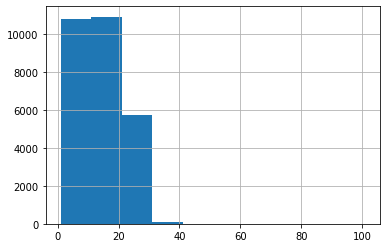

In [9]:
train['lenght'].hist()

In [10]:
train['sentiment'].value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [11]:
train[train['sentiment']=='neutral'].head(5)
# we can see that we select the entier for the neutral sentiment i'm thinking to do a classifcation problem 
# to do classification problem i think is more easy 

,textID,text,selected_text,sentiment,lenght
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,8
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,12
7,50e14c0bb8,Soooo high,Soooo high,neutral,2
8,e050245fbd,Both of you,Both of you,neutral,4
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,24


# 5 FOLDS 

In [12]:
from sklearn import preprocessing
le =preprocessing.LabelEncoder() 
le.fit(train['sentiment'])
train['label'] = le.transform(train['sentiment'])

In [13]:
train['kfold'] = -1 
train = train.sample(frac=1).reset_index(drop=True) 
kf = model_selection.StratifiedKFold(n_splits=5, shuffle = False ,random_state = 42)
for fold,(train_index,test_index) in enumerate(kf.split(X=train,y = train.label.values)) :
    print(len(train_index), len(test_index))
    train.loc[test_index, 'kfold'] = fold

21984 5497
21985 5496
21985 5496
21985 5496
21985 5496


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [14]:
train.to_csv('train_KFold.csv',index=False)

# Roberta Model 

In [15]:
class TweetModel(transformers.BertPreTrainedModel):
    def __init__(self, conf):
        super(TweetModel, self).__init__(conf)
        self.roberta = transformers.RobertaModel.from_pretrained(ROBERTA_PATH, config=conf)
        self.drop_out = nn.Dropout(0.1)
        self.l0 = nn.Linear(768 * 2, 2)
        torch.nn.init.normal_(self.l0.weight, std=0.02)
    
    def forward(self, ids, mask, token_type_ids):
        _, _, out = self.roberta(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        )

        out = torch.cat((out[-1], out[-2]), dim=-1)
        out = self.drop_out(out)
        logits = self.l0(out)

        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

# Datasert Class 

In [16]:
def process_data(tweet, selected_text, sentiment, tokenizer, max_len):
    tweet = " " + " ".join(str(tweet).split())
    selected_text = " " + " ".join(str(selected_text).split())

    len_st = len(selected_text) - 1
    idx0 = None
    idx1 = None

    for ind in (i for i, e in enumerate(tweet) if e == selected_text[1]):
        if " " + tweet[ind: ind+len_st] == selected_text:
            idx0 = ind
            idx1 = ind + len_st - 1
            break

    char_targets = [0] * len(tweet)
    if idx0 != None and idx1 != None:
        for ct in range(idx0, idx1 + 1):
            char_targets[ct] = 1
    
    tok_tweet = tokenizer.encode(tweet)
    input_ids_orig = tok_tweet.ids
    tweet_offsets = tok_tweet.offsets
    
    target_idx = []
    for j, (offset1, offset2) in enumerate(tweet_offsets):
        if sum(char_targets[offset1: offset2]) > 0:
            target_idx.append(j)
    
    targets_start = target_idx[0]
    targets_end = target_idx[-1]

    sentiment_id = {
        'positive': 1313,
        'negative': 2430,
        'neutral': 7974
    }
    
    input_ids = [0] + [sentiment_id[sentiment]] + [2] + [2] + input_ids_orig + [2]
    token_type_ids = [0, 0, 0, 0] + [0] * (len(input_ids_orig) + 1)
    mask = [1] * len(token_type_ids)
    tweet_offsets = [(0, 0)] * 4 + tweet_offsets + [(0, 0)]
    targets_start += 4
    targets_end += 4

    padding_length = max_len - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + ([1] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        tweet_offsets = tweet_offsets + ([(0, 0)] * padding_length)
    
    return {
        'ids': input_ids,
        'mask': mask,
        'token_type_ids': token_type_ids,
        'targets_start': targets_start,
        'targets_end': targets_end,
        'orig_tweet': tweet,
        'orig_selected': selected_text,
        'sentiment': sentiment,
        'offsets': tweet_offsets
    }


In [17]:
class TweetDataset:
    def __init__(self, tweet, sentiment, selected_text):
        self.tweet = tweet
        self.sentiment = sentiment
        self.selected_text = selected_text
        self.tokenizer = TOKENIZER
        self.max_len = MAX_LEN
    
    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, item):
        data = process_data(
            self.tweet[item], 
            self.selected_text[item], 
            self.sentiment[item],
            self.tokenizer,
            self.max_len
        )

        return {
            'ids': torch.tensor(data["ids"], dtype=torch.long),
            'mask': torch.tensor(data["mask"], dtype=torch.long),
            'token_type_ids': torch.tensor(data["token_type_ids"], dtype=torch.long),
            'targets_start': torch.tensor(data["targets_start"], dtype=torch.long),
            'targets_end': torch.tensor(data["targets_end"], dtype=torch.long),
            'orig_tweet': data["orig_tweet"],
            'orig_selected': data["orig_selected"],
            'sentiment': data["sentiment"],
            'offsets': torch.tensor(data["offsets"], dtype=torch.long)
        }

# Engine 

In [18]:
def calculate_jaccard_score(
    original_tweet, 
    target_string, 
    sentiment_val, 
    idx_start, 
    idx_end, 
    offsets,
    verbose=False):
    
    if idx_end < idx_start:
        idx_end = idx_start
    
    filtered_output  = ""
    for ix in range(idx_start, idx_end + 1):
        filtered_output += original_tweet[offsets[ix][0]: offsets[ix][1]]
        if (ix+1) < len(offsets) and offsets[ix][1] < offsets[ix+1][0]:
            filtered_output += " "

    if sentiment_val == "neutral" or len(original_tweet.split()) < 2:
        filtered_output = original_tweet

    if sentiment_val != "neutral" and verbose == True:
        if filtered_output.strip().lower() != target_string.strip().lower():
            print("********************************")
            print(f"Output= {filtered_output.strip()}")
            print(f"Target= {target_string.strip()}")
            print(f"Tweet= {original_tweet.strip()}")
            print("********************************")

    jac = 0
    return jac, filtered_output

In [19]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)
    return total_loss

In [20]:
def train_fn(data_loader, model, optimizer, device, scheduler=None):
    model.train()
    losses = AverageMeter()
    jaccards = AverageMeter()

    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for bi, d in enumerate(tk0):

        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets_start = d["targets_start"]
        targets_end = d["targets_end"]
        sentiment = d["sentiment"]
        orig_selected = d["orig_selected"]
        orig_tweet = d["orig_tweet"]
        targets_start = d["targets_start"]
        targets_end = d["targets_end"]
        offsets = d["offsets"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets_start = targets_start.to(device, dtype=torch.long)
        targets_end = targets_end.to(device, dtype=torch.long)

        model.zero_grad()
        outputs_start, outputs_end = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids,
        )
        loss = loss_fn(outputs_start, outputs_end, targets_start, targets_end)
        loss.backward()
        optimizer.step()
        scheduler.step()

        outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
        outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()
        jaccard_scores = []
        for px, tweet in enumerate(orig_tweet):
            selected_tweet = orig_selected[px]
            tweet_sentiment = sentiment[px]
            jaccard_score, _ = calculate_jaccard_score(
                original_tweet=tweet,
                target_string=selected_tweet,
                sentiment_val=tweet_sentiment,
                idx_start=np.argmax(outputs_start[px, :]),
                idx_end=np.argmax(outputs_end[px, :]),
                offsets=offsets[px]
            )
            jaccard_scores.append(jaccard_score)

        jaccards.update(np.mean(jaccard_scores), ids.size(0))
        losses.update(loss.item(), ids.size(0))
        tk0.set_postfix(loss=losses.avg, jaccard=jaccards.avg)

In [21]:
def calculate_jaccard_score(
    original_tweet, 
    target_string, 
    sentiment_val, 
    idx_start, 
    idx_end, 
    offsets,
    verbose=False):
    
    if idx_end < idx_start:
        idx_end = idx_start
    
    filtered_output  = ""
    for ix in range(idx_start, idx_end + 1):
        filtered_output += original_tweet[offsets[ix][0]: offsets[ix][1]]
        if (ix+1) < len(offsets) and offsets[ix][1] < offsets[ix+1][0]:
            filtered_output += " "

    if sentiment_val == "neutral" or len(original_tweet.split()) < 2:
        filtered_output = original_tweet

    jac = jaccard(target_string.strip(), filtered_output.strip())
    return jac, filtered_output


def eval_fn(data_loader, model, device):
    model.eval()
    losses = AverageMeter()
    jaccards = AverageMeter()
    
    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader))
        for bi, d in enumerate(tk0):
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            sentiment = d["sentiment"]
            orig_selected = d["orig_selected"]
            orig_tweet = d["orig_tweet"]
            targets_start = d["targets_start"]
            targets_end = d["targets_end"]
            offsets = d["offsets"].numpy()

            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets_start = targets_start.to(device, dtype=torch.long)
            targets_end = targets_end.to(device, dtype=torch.long)

            outputs_start, outputs_end = model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids
            )
            loss = loss_fn(outputs_start, outputs_end, targets_start, targets_end)
            outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
            outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()
            jaccard_scores = []
            for px, tweet in enumerate(orig_tweet):
                selected_tweet = orig_selected[px]
                tweet_sentiment = sentiment[px]
                jaccard_score, _ = calculate_jaccard_score(
                    original_tweet=tweet,
                    target_string=selected_tweet,
                    sentiment_val=tweet_sentiment,
                    idx_start=np.argmax(outputs_start[px, :]),
                    idx_end=np.argmax(outputs_end[px, :]),
                    offsets=offsets[px]
                )
                jaccard_scores.append(jaccard_score)

            jaccards.update(np.mean(jaccard_scores), ids.size(0))
            losses.update(loss.item(), ids.size(0))
            tk0.set_postfix(loss=losses.avg, jaccard=jaccards.avg)
    
    print(f"Jaccard = {jaccards.avg}")
    return jaccards.avg

In [22]:
!mkdir models

In [23]:
def run(fold):
    dfx = pd.read_csv('train_KFold.csv')

    df_train = dfx[dfx.kfold != fold].reset_index(drop=True)
    df_valid = dfx[dfx.kfold == fold].reset_index(drop=True)
    
    train_dataset = TweetDataset(
        tweet=df_train.text.values,
        sentiment=df_train.sentiment.values,
        selected_text=df_train.selected_text.values
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=4
    )

    valid_dataset = TweetDataset(
        tweet=df_valid.text.values,
        sentiment=df_valid.sentiment.values,
        selected_text=df_valid.selected_text.values
    )

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=2
    )

    device = torch.device("cuda")
    model_config = transformers.RobertaConfig.from_pretrained(ROBERTA_PATH)
    model_config.output_hidden_states = True
    model = TweetModel(conf=model_config)
    model.to(device)

    num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]
    optimizer = AdamW(optimizer_parameters, lr=3e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0, 
        num_training_steps=num_train_steps
    )

    print(f"Training is Starting for fold={fold}")
    
    # I'm training only for 3 epochs even though I specified 5!!!
    for epoch in range(EPOCHS):
        train_fn(train_data_loader, model, optimizer, device, scheduler=scheduler)
        jaccard = eval_fn(valid_data_loader, model, device)
        print(f"Jaccard Score = {jaccard}")
        torch.save(model.state_dict(),f'../working/models/model_fold{fold}.bin')


# Model Training 

In [24]:
MAX_LEN = 192
TRAIN_BATCH_SIZE = 48
VALID_BATCH_SIZE = 8
EPOCHS = 6
ROBERTA_PATH = "../input/roberta-base"
TOKENIZER = tokenizers.ByteLevelBPETokenizer(
    vocab_file=f"{ROBERTA_PATH}/vocab.json", 
    merges_file=f"{ROBERTA_PATH}/merges.txt", 
    lowercase=True,
    add_prefix_space=True
)

In [25]:
device = torch.device("cuda")

In [26]:
run(0)


Training is Starting for fold=0



Jaccard = 0.6938866693488852
Jaccard Score = 0.6938866693488852



Jaccard = 0.7001147340648132
Jaccard Score = 0.7001147340648132



Jaccard = 0.7018875422878484
Jaccard Score = 0.7018875422878484



Jaccard = 0.7041980816481327
Jaccard Score = 0.7041980816481327


In [27]:
run(1)

Training is Starting for fold=1



Jaccard = 0.6926890361495042
Jaccard Score = 0.6926890361495042



Jaccard = 0.7035059459790296
Jaccard Score = 0.7035059459790296



Jaccard = 0.7028898879599826
Jaccard Score = 0.7028898879599826



Jaccard = 0.7037174269310787
Jaccard Score = 0.7037174269310787


In [28]:
run(2)

Training is Starting for fold=2



Jaccard = 0.693789109901741
Jaccard Score = 0.693789109901741



Jaccard = 0.7065509548947675
Jaccard Score = 0.7065509548947675



Jaccard = 0.709462372558489
Jaccard Score = 0.709462372558489



Jaccard = 0.7056515929168687
Jaccard Score = 0.7056515929168687


In [29]:
run(3)

Training is Starting for fold=3



Jaccard = 0.7025708879364615
Jaccard Score = 0.7025708879364615



Jaccard = 0.7099861243080094
Jaccard Score = 0.7099861243080094



Jaccard = 0.7109491305204916
Jaccard Score = 0.7109491305204916



Jaccard = 0.7104579771843538
Jaccard Score = 0.7104579771843538


In [30]:
run(4)

Training is Starting for fold=4



Jaccard = 0.7007889374039751
Jaccard Score = 0.7007889374039751



Jaccard = 0.7025231101061388
Jaccard Score = 0.7025231101061388



Jaccard = 0.7012522528002743
Jaccard Score = 0.7012522528002743



Jaccard = 0.7057395909691339
Jaccard Score = 0.7057395909691339



Jaccard = 0.7036963815229361
Jaccard Score = 0.7036963815229361


In [31]:
run(5)

Training is Starting for fold=5



Jaccard = 0
Jaccard Score = 0



Jaccard = 0
Jaccard Score = 0



Jaccard = 0
Jaccard Score = 0



Jaccard = 0
Jaccard Score = 0



Jaccard = 0
Jaccard Score = 0



Jaccard = 0
Jaccard Score = 0


In [32]:
model_config = transformers.RobertaConfig.from_pretrained(f"{ROBERTA_PATH}/roberta-large-config.json")
model_config.output_hidden_states = True
model = TweetModel(conf=model_config)

OSError: Can't load '../input/roberta-base/roberta-large-config.json'. Make sure that:

- '../input/roberta-base/roberta-large-config.json' is a correct model identifier listed on 'https://huggingface.co/models'

- or '../input/roberta-base/roberta-large-config.json' is the correct path to a directory containing a 'config.json' file



In [33]:
model.load_state_dict(torch.load("../working/models/model_fold0.bin"))

NameError: name 'model' is not defined